Clasificación usando perceptrones continuos
===

* *30 min* | Última modificación: Marzo 22, 2020

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline

## Definición del problema

Se tiene una muestra de 150 ejemplos, con dos variables independientes y tres clases; cada clase tiene 50 ejemplos. Se desea construir un sistema clasificador que permita discriminar a que clase pertenece un nuevo patrón. Los ejemplos son generados artificialmente a continuación.

In [2]:
from sklearn.datasets import make_blobs

NPOINTS = 150

X, d = make_blobs(
    n_samples=NPOINTS, 
    n_features=2,
    centers=3,
    cluster_std=0.8, 
    shuffle=False,  
    random_state=12345)

En la siguiente gráfica cada color representa una clase diferente.

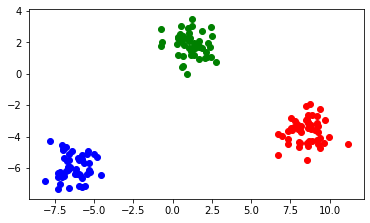

In [3]:
plt.scatter(X[:50,0], X[:50,1], color='red')
plt.scatter(X[50:100,0], X[50:100,1], color='blue')
plt.scatter(X[100:,0], X[100:,1], color='green')
plt.gca().set_aspect('equal', adjustable='box')

## Solución

Se usa la misma implementación del tutorial anterior.

In [4]:
class ContinuousPerceptron:
    def __init__(self, 
                 learning_rate=0.001, # tasa de aprendizaje
                 max_epochs=100,      # número máximo de iteraciones sobre el set de datos
                 shuffle=False,       # mezcla patrones para aprendizaje online
                 batch=False,         # ?batch o online
                 random_state=None,   #
                 warm_start=False):   #
        
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.shuffle = shuffle
        self.batch = batch
        self.random_state = random_state
        self.warm_start = warm_start
        self.coef_ = None
        self.intercept_ = None
        
    def fit(self, X, y):
        
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        if not isinstance(y, np.ndarray):
            d = np.array(y)
        else:
            d = y.copy()
            
        if self.random_state is not None:
            np.random.RandomState(self.random_state)

        if self.coef_ is None or self.warm_start is False:
            self.coef_ = np.random.uniform(-1, 1, X.shape[1])
            
        if self.intercept_ is None  or self.warm_start is False:
            self.intercept_ = np.random.uniform(-1, 1, 1)

        history = []            
        
        if self.batch is True:
            for epoch in range(self.max_epochs):
                u = np.dot(X, self.coef_) + self.intercept_
                s = 1. / (1. + np.exp(-u))
                e = d - s
                self.coef_ += 2 * self.learning_rate * np.sum((X.T * e * s * (1. - s)).T, axis=0)
                self.intercept_ += 2 * self.learning_rate * np.sum((e * s * (1. - s)).T, axis=0)
                history.append(sum([a**2 for a in e]))            
        else:
            
            for epoch in range(self.max_epochs):
            
                if self.shuffle is True:
                    n = list(range(X.shape[0]))
                    np.random.shuffle(n)
                    X = X[n,:]
                    d = d[n]
                    
                for i in range(X.shape[0]):
                    u = np.dot(X[i,:], self.coef_) + self.intercept_
                    s = (1. / (1. + np.exp(-u)))
                    e = (d[i] - s)[0]
                    self.coef_ += 2 * self.learning_rate * e * s * (1-s) * X[i,:]
                    self.intercept_ += 2 * self.learning_rate * e * s * (1-s)
                    history.append(e**2)    

        return history
                    
    def predict(self, X):
        if not isinstance(X, np.ndarray):
            X = np.array(X)        
        u = np.dot(X, self.coef_) + self.intercept_
        return 1. / (1. + np.exp(-u))

La variable `d` codifica la clase a la que pertenece cada patrón de ejemplo.

In [5]:
d

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Sin embargo, la salida del perceptrón es un número entre 0 y 1, donde 0 representa la absoluta certeza de que el patrón no pertence a una clase determinada, y el 1 representa la absoluta certeza de que si pertenece.

Ya que el problema tiene 3 clases, se crean tres variables `A`, `B` y `C`, que indica respectivamente que el patrón pertence o no a la primera clase, que pertence o no a la segunda clase, y, finalmente, que pertence o no pertence a la tercera clase.

In [6]:
A = [1 if u == 0 else 0 for u in d]
B = [1 if u == 1 else 0 for u in d]
C = [1 if u == 2 else 0 for u in d]

Esto es, `A` vale 1 si el patrón pertence a la primera clase y cero en caso contrario.

Se crean tres modelos y se entrenan:

In [7]:
max_epochs = 2000


mA = ContinuousPerceptron(
    learning_rate=0.001, 
    max_epochs=max_epochs, 
    batch=True)

historyA = mA.fit(X, A)


mB = ContinuousPerceptron(
    learning_rate=0.001, 
    max_epochs=max_epochs, 
    batch=True)

historyB = mB.fit(X, B)


mC = ContinuousPerceptron(
    learning_rate=0.001,
    max_epochs=max_epochs,
    batch=True)

historyC = mC.fit(X, C)

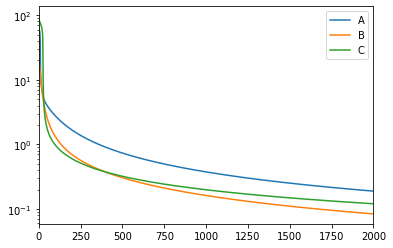

In [8]:
#
# Evolución del error
#
plt.plot(historyA)
plt.plot(historyB)
plt.plot(historyC);
plt.legend(['A', 'B', 'C']);
plt.xlim(0, max_epochs)
plt.yscale('log');

Con los modelos entrenados, se realiza el pronóstico para el patron `(2.5, -4.0)`, que no pertence a la muestra de datos.

In [9]:
print(mA.predict([[2.5, -4.0]]), 
      mB.predict([[2.5, -4.0]]),
      mC.predict([[2.5, -4.0]]))

# el punto pertence a la clase B (valor más alto)

[0.66901627] [0.77413817] [0.00362753]


A contiuación se grafican las fronteras de decisión generadas por cada clasificador.

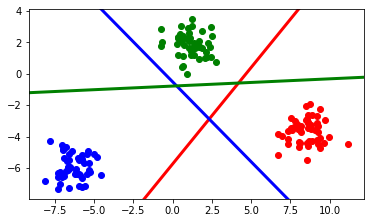

In [10]:
plt.scatter(X[:50,0], X[:50,1], color='red')
plt.scatter(X[50:100,0], X[50:100,1], color='blue')
plt.scatter(X[100:,0], X[100:,1], color='green')
plt.gca().set_aspect('equal', adjustable='box')

xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()

xplot = np.linspace(start=xlim[0], stop=xlim[1], num=20)
fronteraA = - mA.intercept_ / mA.coef_[1] - mA.coef_[0] / mA.coef_[1] * xplot
fronteraB = - mB.intercept_ / mB.coef_[1] - mB.coef_[0] / mB.coef_[1] * xplot
fronteraC = - mC.intercept_ / mC.coef_[1] - mC.coef_[0] / mC.coef_[1] * xplot

plt.plot(xplot, fronteraA, color='red', linewidth=3)
plt.plot(xplot, fronteraB, color='blue', linewidth=3)
plt.plot(xplot, fronteraC, color='green', linewidth=3);

plt.xlim(xlim)
plt.ylim(ylim);

**Ejercicio.---** ¿Cuál es la región que no es asignada a ninguna clase?

**Ejercicio.---** ¿Cuales son las regiones que pertenecen a más de una clase?

## Relación entre la regresión logística y el perceptrón continuo

La regresión logística usa el mismo modelo matemático del perceptrón continuo, cuyos parámetros óptimos son obtenidos minimizando la función de entropía cruzada:

$$ \frac{1}{P} \sum_i^P d_i \cdot \log(y_i) + 
(1-d_i) \cdot \log(1- y_i)
$$ 

la cual es computada sobre todo el conjunto de datos.